# Project 2: Building a Color Magnitude Diagram of Open and Globular Clusters

NAME: 

UTEID: 

DATE:


Goals: The goal is to use Gaia data to find clusters in 2 'pointings' and plot 

Data sets: 
1. pointing1.fits [4.7MB] = this contains the data from a single pointing in Gaia DR3; https://utexas.box.com/s/iuoge4sslbqdp4bc01znzxueugdl1ui7
2. pointing2.fits [6.6MB] = this contains the data from a second single pointing in Gaia DR3; https://utexas.box.com/s/hd3086ctmrilxq0v8pq6rted2cgd68k8


Lets begin by loading our libraries: 



In [1]:
#lets make a plots interactive
%matplotlib inline 

#Importing libraries 
import numpy as np
import matplotlib.pyplot as p
import astropy
from astropy.table import Table
import scipy.stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
import astropy.coordinates as apycord
import random
from cycler import cycler
import astropy.table

#Lets set some of the default parameters for plotting. This cell is not needed but i like to style my plots.
p.rc('axes',prop_cycle=(cycler('color', ['k','b','g','r','c','m','y'])))
p.rcParams['lines.linewidth']= 1.5
p.rcParams['axes.linewidth']=2.0
#---comment (or remove) this block if you do not have latex----
p.rcParams['text.usetex']= True
p.rcParams['mathtext.fontset']= 'custom'
p.rcParams['mathtext.default']= 'rm'
p.rcParams['axes.formatter.use_mathtext']=False
#----------------------------------------
p.rcParams['font.size']= 15.0
p.rcParams['axes.labelsize']=16.0
p.rcParams['axes.unicode_minus']=False
p.rcParams['xtick.major.size']=6
p.rcParams['xtick.minor.size']=3
p.rcParams['xtick.major.width']=1.5#2.0
p.rcParams['xtick.minor.width']=1.0
p.rcParams['axes.linewidth']=2.5
p.rcParams['axes.titlesize']=20#'large'
p.rcParams['xtick.labelsize'] = 20#'x-large' # fontsize of the tick labels
p.rcParams['ytick.labelsize']=20 #'x-large'
p.rcParams['ytick.major.width']=2.0 #4
p.rcParams['ytick.minor.width']=1.0 #2.0

## Loading the Data for the first pointing 
Now lets load in the Dataset for the first pointing and see whats inside (i.e. print the column names)

In [2]:
T = Table.read('./NGC188_in.fits')
T.remove_columns(['l','b']) #accidently added l and b so remove these for simplicity
T = T[np.where(T['ra']<=50)] #lets cut off when ra ~360 degrees by capping at RA < 50 (makes plots look nicer)
COLS = T.colnames 
print(COLS)


['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'pmra_error', 'pmdec_error', 'ag_gspphot', 'azero_gspphot', 'bp_rp', 'ebpminrp_gspphot', 'radial_velocity', 'radial_velocity_error']


## Fake Cluster in Pointing 1 

Lets make a fake cluster for pointing 1 (this will be in the soultions for completness but not the template).

This will not be in the template but lets start making some "FAKE" clusters to make sure the students can distingish between real and fake clusters

In [3]:
## lets start by make a fake cluster 
N_star_fake = [400,560] #how many fake stars and clusters? 
locs = [[10,85.8], [11.6,84.6]] # where do we put the fake cluster in RA/DEC
sizes = [[1, 0.1], [1,0.1]] #how large to make the cluster in ra/dec
for i in range(len(N_star_fake)): #loop over all fake clusters
    if i ==1:
        #remove this block if we want to make 2 fake clusters
        continue 
    A = []
    #make a cluster that is Guassian in RA/DEc
    ras = np.random.normal(locs[i][0],sizes[i][0], size= N_star_fake[i])
    decs = np.random.normal(locs[i][1],sizes[i][1], size= N_star_fake[i])
    #---make fake source ids so i can find the fake cluster later
    source_ids = ['540002456920093'+'%03i'%j for j in range(N_star_fake[i])]
    if i == 0:
        # -- lets make it so that the pmra and pmdec are clustered (Guassian) but parallax is uniform (i.e. not a real cluster)
        parallaxs = np.random.uniform(0,1.2, size= N_star_fake[i])
        pmras = np.random.normal(2,0.11, size= N_star_fake[i])
        pmdecs = np.random.normal(4,0.10, size= N_star_fake[i])
    elif i == 1:
        # -- lets make it so that the parallax is cluster but not PMRA/PMDEC

        parallaxs = np.random.normal(0.9,0.01, size= N_star_fake[i])
        pmras = np.random.uniform(np.nanmin(T['pmra']),np.nanmax(T['pmra']), size= N_star_fake[i])
        pmrdecs = np.random.uniform(np.nanmin(T['pmdec']),np.nanmax(T['pmdec']), size= N_star_fake[i])
    A = Table() ; A['source_id'] = source_ids ; A['ra'] = ras; A['dec'] = decs; A['parallax'] = parallaxs
    A['pmra'] = pmras;A['pmdec'] = pmdecs
    for k in range(len(COLS[6:])):
        #A.append( np.random.uniform(np.nanmin(T[COLS[k+6]]),np.nanmax(T[COLS[k+6]]), size= N_star_fake[i])  )
        A[COLS[k+6]] = np.random.uniform(np.nanmin(T[COLS[k+6]]),np.nanmax(T[COLS[k+6]]), size= N_star_fake[i])
        T = astropy.table.vstack([T,A])
print(T)

    source_id              ra         ... radial_velocity_error
                          deg         ...         km / s       
------------------ ------------------ ... ---------------------
574053612113914880 3.7005149342773342 ...                   nan
574053616408992256  3.771305101604993 ...                   nan
574053753848593536 3.2482962375558326 ...                   nan
574053783912601344  3.520913828391704 ...                   nan
574053783912608640 3.3461253245341953 ...                   nan
574053788207614208  3.411162564634185 ...                   nan
574053818271924096   3.38236383096802 ...                   nan
574053818272063872 3.4032108631413704 ...                   nan
574053818272347264 3.4689453458750945 ...                   nan
574053818272350464  3.465682458957926 ...                   nan
               ...                ... ...                   ...
540002456920093390  9.982935792526352 ...    13.571350882682406
540002456920093391 10.698224707541923 ..

In [4]:
 #overwrite the old file with a new on with the fake clusters
#T.write('./pointing1.fits',overwrite=True)

## Fake Cluster in Pointing 2

Lets make a fake cluster for pointing 2 (this will be in the soultions for completness but not the template).

['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'ag_gspphot', 'azero_gspphot', 'bp_rp', 'ebpminrp_gspphot', 'radial_velocity', 'radial_velocity_error']


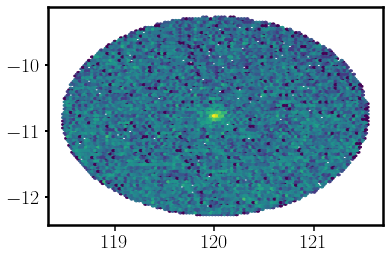

In [5]:
#lets load in the second pointing 
T2 = Table.read('./NGC2506.fits') #1 pt
T2 = T2[np.where(T2['parallax']<3)[0]]
COLS = T2.colnames
print(COLS)
#lets make a sky plot so i know where to put the clusters
p.figure()
p.hexbin(T2['ra'],T2['dec'],bins='log',mincnt=1)

     source_id              ra         ... radial_velocity_error
                           deg         ...         km / s       
------------------- ------------------ ... ---------------------
3039002727032934272 120.37062687792344 ...                   nan
3039002791454795264 120.35630375196034 ...                   nan
3039002795752413952 120.35644230090544 ...                   nan
3039002795752418816 120.34898926869961 ...                   nan
3039002795753654528 120.34547277880894 ...                   nan
3039002825814561536 120.36635975416503 ...                   nan
3039002830112145536 120.36917882003377 ...                   nan
3039002830112146048 120.36664544296738 ...                   nan
3039003448587459328 120.32514278668481 ...                   nan
3039003620386141568  120.3357096815728 ...                   nan
                ...                ... ...                   ...
 540002456920091550 119.98843024631823 ...    12.180170900389482
 540002456920091551 120.2

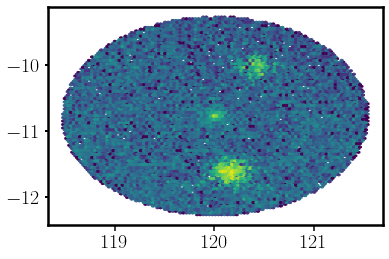

In [6]:
#using the above lets insert !2 fake clusters into pointing two

## lets start by make a fake cluster 
N_star_fake = [200,560] #how many fake stars and clusters? 
locs = [[120.426,-10.023], [120.17,-11.617]] # where do we put the fake cluster in RA/DEC
sizes = [[0.1, 0.1], [0.1,0.1]] #how large to make the cluster in ra/dec
for i in range(len(N_star_fake)): #loop over all fake clusters
    #if i ==1:
        #remove this block if we want to make 2 fake clusters
        #continue 
    A = []
    #make a cluster that is Guassian in RA/DEc
    ras = np.random.normal(locs[i][0],sizes[i][0], size= N_star_fake[i])
    decs = np.random.normal(locs[i][1],sizes[i][1], size= N_star_fake[i])
    #---make fake source ids so i can find the fake cluster later
    source_ids = ['54000245692009%i'%i+'%03i'%j for j in range(N_star_fake[i])]
    if i == 0:
        # -- lets make it so that the pmra and pmdec are clustered (Guassian) but parallax is uniform (i.e. not a real cluster)
        parallaxs = np.random.uniform(0,1.2, size= N_star_fake[i])
        pmras = np.random.uniform(-5,0, size= N_star_fake[i])
        pmdecs = np.random.uniform(-20,-40, size= N_star_fake[i])
    elif i == 1:
        # -- lets make it so that the parallax is cluster but not PMRA/PMDEC
        parallaxs = np.random.uniform(0,1.3, size= N_star_fake[i])
        pmras = np.random.uniform(-5,0, size= N_star_fake[i])
        pmdecs = np.random.uniform(-40,-45, size= N_star_fake[i])

        
    #write to a temp table     
    A = Table() ; A['source_id'] = source_ids ; A['ra'] = ras; A['dec'] = decs; A['parallax'] = parallaxs
    A['pmra'] = pmras;A['pmdec'] = pmdecs
    for k in range(len(COLS[6:])):
        #add row information sampling from a random distrubtion.
        A[COLS[k+6]] = np.random.uniform(np.nanmin(T2[COLS[k+6]]),np.nanmax(T2[COLS[k+6]]), size= N_star_fake[i])
        #conctat the temp and main tabkles
        T2 = astropy.table.vstack([T2,A])
print(T2)

p.figure()
p.hexbin(T2['ra'],T2['dec'],bins='log',mincnt=1)

lets write out the second pointing data

In [7]:
#T2.write('./pointing2.fits',overwrite=True)

Now we have the datasets in hand... lets pass this to the students.

Goodluck ! 

(START Template here)

## Load in Pointing 1
Lets begin with 1 pointing at a time to make things easier. 


Further, lets start by loading in the data for pointing 1 (first) and see whats there.

In [8]:
# 2pts 
#insert code here

In [9]:
T = Table.read('./pointing1.fits') 
print(T.colnames)

['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'pmra_error', 'pmdec_error', 'ag_gspphot', 'azero_gspphot', 'bp_rp', 'ebpminrp_gspphot', 'radial_velocity', 'radial_velocity_error']


You should get something like the following columns
'source_id' = source id of the star

 'source_id' = source id of the star
 
 'ra', = RA in deg 
 
 'dec', = declination in deg
 
 'parallax', = parallax in mas
 
 'pmra', = proper motion * cos(DEC) in the RA direction in mas/yr
 
 'pmdec', proper motion in declination in in mas/yr
 
 'phot_g_mean_mag', apparent G magnitude in mag
 
 'phot_bp_mean_mag',apparent BP magnitude in mag
 
 'phot_rp_mean_mag',apparent RP magnitude in mag
 
 'pmra_error', = error in proper motion * cos(DEC) in the RA direction in mas/yr
 
 'pmdec_error', error proper motion in declination in mas/yr
 
 'ag_gspphot', A_G (extinction in Gaia G) in mag
 
 'azero_gspphot', A0_G specific extinction in G at 550 nm 
 
 'bp_rp', BP-RP

 
 'ebpminrp_gspphot', E(BP-RP) reddening in mag
 
 
 'radial_velocity' = Radial Velocity in km/s
 
 'radial_velocity_error' = error Radial Velocity in km/s
 

## Plot the Equatorial positions for Pointing 1


Plot a 2-D histogram (hexbin) of the sky positions of the stars in pointing 1

In [10]:
# 4pts 
#insert code here

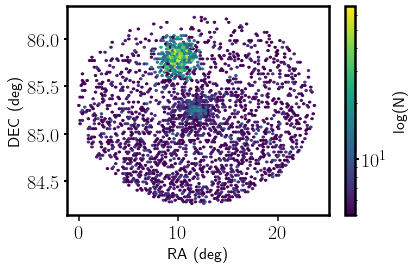

In [11]:
#plotting Equatorial coordinates in a 2-d histogram. DO NOT USE PLOT because it will take a long time to render
p.figure()
s= p.hexbin(T['ra'],T['dec'], bins='log',mincnt=5)
p.colorbar(s,label='log(N)')
p.xlabel('RA (deg)');p.ylabel('DEC (deg)')
p.tight_layout()
#plotting Galactic coordinates in a 2-d histogram. DO NOT USE PLOT because it will take a long time to render

#try changing the mincnt in the hexbin from 1 to 5 and see what happens 



Q1: Are there any overdensities  in the field/pointing? If so, how many?

A1: YES, 2

If there are any overdensities select them using the where function and print how many stars are in each.

In [12]:
#3pts 
#insert code here
#Remember that conditions must be in the form: np.where((condition 1)&(condition 2) & (...))[0]

In [13]:
#-- select any overdensities with the where function. Remember that conditions must be in the form:
# np.where((condition 1)&(condition 2) & (...))[0]

OV1 = np.where((T['dec'] > 85.086)& (T['dec'] < 85.431) & (T['ra'] < 14.60) & (T['ra'] > 9.84 ))[0] 
OV2 = np.where((T['dec'] > 85.585)& (T['dec'] < 86.037) & (T['ra'] < 12.70) & (T['ra'] > 7.38 ))[0] 

print('There are %i stars in OV1 and %i stars in OV2'%(len(OV1),len(OV2)))

There are 2233 stars in OV1 and 5819 stars in OV2


## Finding Clusters in Pointing 1

We must now turn our attention to determining if any of the overdensities (if there were any) are actual clusters or not. 

We will start by looking at the PMRA/PMDEC space and the the parallax distribution of any overdensities that were found in the spatial plots above. 

Lets now plot the 2d distribution (hexbin) of  PMRA and PMDEC for any spatial overdensity regions seperatly (make sure to label the plot using plt.title('name of the plot'). I would HIGHLY reccomend using a mincount (mincnt) of 1 stars per bin, log bins, a gridsize (gridsize=150).  

In [14]:
#8pts
#insert code here

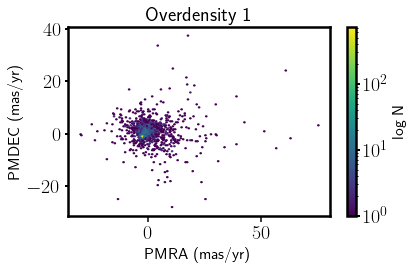

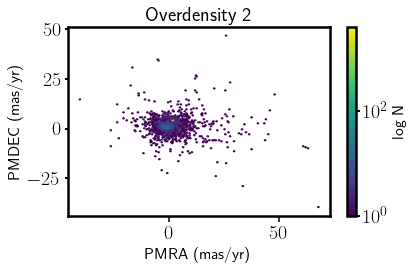

In [15]:
p.figure()
s = p.hexbin(T['pmra'][OV1],T['pmdec'][OV1],bins='log',mincnt=1,gridsize=150)
p.colorbar(s,label='log N')
p.xlabel('PMRA (mas/yr)')
p.ylabel('PMDEC (mas/yr)')
p.title('Overdensity 1')
p.tight_layout()


p.figure()
s = p.hexbin(T['pmra'][OV2],T['pmdec'][OV2],bins='log',mincnt=1,gridsize=150)
p.colorbar(s,label='log N')
#p.plot(T['pmra'][OV1],T['pmdec'][OV1],'k.',alpha=0.4,label='OV1')
#p.plot(T['pmra'][OV2],T['pmdec'][OV2],'r.',alpha=0.4,label='OV2')
p.xlabel('PMRA (mas/yr)')
p.ylabel('PMDEC (mas/yr)')
p.title('Overdensity 2')
p.tight_layout()


Q2: Are there any overdensities found in the PMRA/PMDEC plot of any of the spatially dense regions (in RA/DEC)? If so, what do these mean?

A2: Yes each spatially dense region has a single overdensity meaning that there are starts in that spatially dense region that are all moving together in the same direction at the same amplitude. This is exactly what we need for a cluster. But we will need to check that the stars are co-located in the same 3-d sapce.

For all spatial overdensitites identify the location of the proper motion overdensity (if any) using the where function. Make sure to be careful with indexing. 

In [16]:
#4 pts 
#insert code here

In [17]:
OV1_PM = np.where((T['pmra'][OV1] >-3.35) & (T['pmra'][OV1] <-1.05) & \
                  (T['pmdec'][OV1] >-1.63) & (T['pmdec'][OV1] <-0.45) )[0]

OV2_PM = np.where((T['pmra'][OV2] >1.46) & (T['pmra'][OV2] <2.94 ) & \
                  (T['pmdec'][OV2] >3.25) & (T['pmdec'][OV2] <4.45) )[0]

CL1 = OV1[OV1_PM]
CL2 = OV2[OV2_PM]

Now, plot the parallax distrubtion (on a single plot/figure) for each cluster candidate

In [18]:
#4 pts
#insert code here.

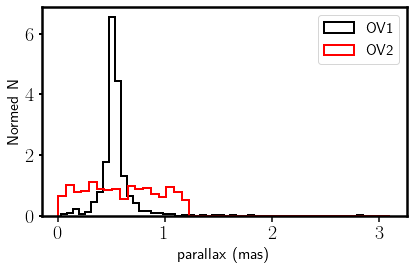

In [19]:
p.figure()
p.hist(T['parallax'][CL1], color='k',histtype='step',label='OV1',lw=2,density=True,bins='scott')
p.hist(T['parallax'][CL2], color='r',histtype='step',label='OV2',lw=2,density=True,bins='scott')
p.legend()
p.xlabel('parallax (mas)');p.ylabel('Normed N')
p.tight_layout()


Q3 : How many real clusters are in Pointing 1? How do you know?

A3: There is 1 cluster in pointing 1 since it clumps in ra/dec/parallax/pmra/pmdec space. The parallax distribution of the second overdensity is uniform NOT peaked as such the stars are uniformly distributed along the line of sight. Therefore cluster 2 is *NOT* a cluster. NOTE: It also clumps in RV space but there are not enough RVs 


For any real cluster, compute the median and standard deivation of the parallaxes

In [20]:
#2 pts
#insert code here

In [21]:
medpar = np.median(T['parallax'][CL1])
stdpar = np.std(T['parallax'][CL1])
print('The median (std) parallax is %.2f (%.2f) with %i stars'%(medpar, stdpar, len(CL1)))

The median (std) parallax is 0.52 (0.16) with 986 stars


Q4: What is the median distance to any clusters you found (ignore the effects of parallax uncertainties)?

A4: The cluster is NGC 188. The median parallax is 0.52-0.63 mas and thus this cluster is at a distance of 1.58-1.92 kpc (true cluster distance ~1.66kpc)

## Plot the Color-Abs magnitude Diagram for Clusters in Pointing 1
Lets now plot the Color (bp-rp) - absolute magntiude (M_G) diagram for each cluster found in pointing 1. Lets make sure to plot them on the same diagram for comparision.  

In [22]:
#8 pts
#insert code here

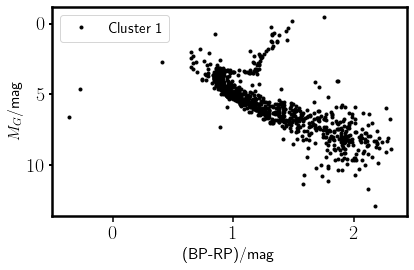

In [23]:
#lets now compute the absolute magnitude
T['absG'] = T['phot_g_mean_mag'] - 5*(np.log10(1000/T['parallax'])-1)
#lets now plot any found clusters on the same diagram!
p.figure()
p.plot(T['bp_rp'][CL1], T['absG'][CL1],'k.',label='Cluster 1')
p.xlabel('(BP-RP)/mag')
p.ylabel(r'$M_G$/mag')
p.legend()
p.gca().invert_yaxis()
p.tight_layout()

## Load in Pointing 2
Lets now move to the second pointing 

Its easiest to begin by loading in the data and seeing whats there.

In [24]:
# 2pts 
#insert code here

In [25]:
T2 = Table.read('./pointing2.fits')
print(T.colnames)

['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'pmra_error', 'pmdec_error', 'ag_gspphot', 'azero_gspphot', 'bp_rp', 'ebpminrp_gspphot', 'radial_velocity', 'radial_velocity_error', 'absG']


You should get something like the following columns
'source_id' = source id of the star

 'source_id' = source id of the star
 
 'ra', = RA in deg 
 
 'dec', = declination in deg
 
 'parallax', = parallax in mas
 
 'pmra', = proper motion * cos(DEC) in the RA direction in mas/yr
 
 'pmdec', proper motion in declination in in mas/yr
 
 'phot_g_mean_mag', apparent G magnitude in mag
 
 'phot_bp_mean_mag',apparent BP magnitude in mag
 
 'phot_rp_mean_mag',apparent RP magnitude in mag
  
 'ag_gspphot', A_G (extinction in Gaia G) in mag
 
 'azero_gspphot', A0_G specific extinction in G at 550 nm 
 
 'bp_rp', BP-RP
 
 'ebpminrp_gspphot', E(BP-RP) reddening in mag
 
 'radial_velocity' = Radial Velocity in km/s
 
 'radial_velocity_error' = error Radial Velocity in km/s
 

## Plot the Equatorial positions for Pointing 2


Plot a 2-D histogram (hexbin) of the sky positions of the stars in pointing 2

In [26]:
# 4pts 
#insert code here

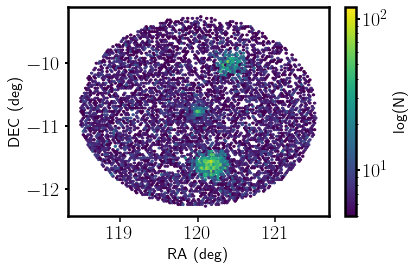

In [27]:
#plotting Equatorial coordinates in a 2-d histogram. DO NOT USE PLOT because it will take a long time to render
p.figure()
s= p.hexbin(T2['ra'],T2['dec'], bins='log',mincnt=5)
p.colorbar(s,label='log(N)')
p.xlabel('RA (deg)');p.ylabel('DEC (deg)')
p.tight_layout()
#plotting Galactic coordinates in a 2-d histogram. DO NOT USE PLOT because it will take a long time to render

#try changing the mincnt in the hexbin from 1 to 5 and see what happens 



Q5: Are there any overdensitites in the pointing 2? If so, how many?

A5: YES, 3

If there are any overdensities select them using the where function and print how many stars are in each.

In [28]:
#4pts 
#insert code here
#Remember that conditions must be in the form: np.where((condition 1)&(condition 2) & (...))[0]

In [29]:
#-- select any overdensities with the where function. Remember that conditions must be in the form:
# np.where((condition 1)&(condition 2) & (...))[0]

OV1 = np.where((T2['dec'] > -10.21)& (T2['dec'] < -9.858) & (T2['ra'] < 120.6) & (T2['ra'] > 120.264 ))[0] 
OV2 = np.where((T2['dec'] > -10.892 )& (T2['dec'] < -10.669 ) & (T2['ra'] < 120.104) & (T2['ra'] > 119.909 ))[0]  
OV3 = np.where((T2['dec'] > -11.82)& (T2['dec'] < -11.365) & (T2['ra'] < 120.351) & (T2['ra'] > 120.011 ))[0] 

print('There are %i stars in OV1 and %i stars in OV2 and %i in OV3'%(len(OV1),len(OV2),len(OV3)))

There are 2200 stars in OV1 and 816 stars in OV2 and 5471 in OV3


## Finding Clusters in Pointing 2

We must now turn our attention to determining if any of the overdensities (if there were any) are actual clusters or not. 

If there are any overdensities plot the parallax distrbtion of each overdensity on a single plot. The bins should use "Scott's" rule. 

Lets now plot the 2d distribution (hexbin) of  PMRA and PMDEC for any spatial overdensity regions seperatly (make sure to label the plot using plt.title('name of the plot'). I would HIGHLY reccomend using a mincount (mincnt) of 1 stars per bin, log bins, a gridsize (gridsize=50).  

In [30]:
#12pts
#insert code here

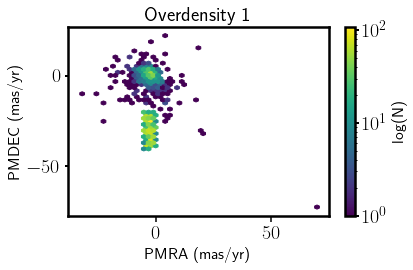

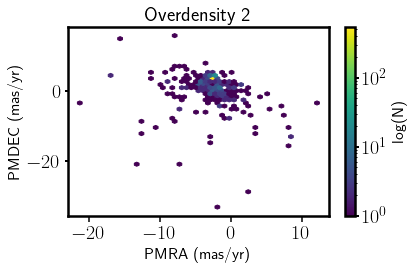

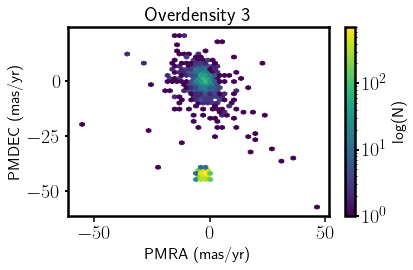

In [31]:
p.figure()
s = p.hexbin(T2['pmra'][OV1],T2['pmdec'][OV1],bins='log',mincnt=1,gridsize=50)
p.colorbar(s,label='log(N)')
p.xlabel('PMRA (mas/yr)')
p.ylabel('PMDEC (mas/yr)')
p.title('Overdensity 1')
p.tight_layout()


p.figure()
s = p.hexbin(T2['pmra'][OV2],T2['pmdec'][OV2],bins='log',mincnt=1,gridsize=50)
p.colorbar(s,label='log(N)')
p.xlabel('PMRA (mas/yr)')
p.ylabel('PMDEC (mas/yr)')
p.title('Overdensity 2')
p.tight_layout()

p.figure()
s = p.hexbin(T2['pmra'][OV3],T2['pmdec'][OV3],bins='log',mincnt=1,gridsize=50)
p.colorbar(s,label='log(N)')
p.xlabel('PMRA (mas/yr)')
p.ylabel('PMDEC (mas/yr)')
p.title('Overdensity 3')
p.tight_layout()


Q6: Are there any *significant* (key word significant meaning well above the background) overdensities found in the PMRA/PMDEC plot(s) of any of the spatially dense regions (in RA/DEC)? If so, what do these mean?

A6: Yes each spatially dense region has a single overdensity meaning that there are starts in that spatially dense region that are all moving together in the same direction at the same amplitude. This is exactly what we need for a cluster. But we will need to check that the stars are co-located in the same 3-d sapce. NOTE that Clusters 1,3 the overdensity in PMRA/PMDEC are WAY too large (i.e. the stars aren't truly moving together)

For all (signficant) spatial overdensitites identify the location of the proper motion overdensity (if any) using the where function. Be very careful about your indexing, and the use of where with negative numbers.

In [32]:
#3 pts
#insert code here

In [33]:
OV1_PM = np.where((T2['pmra'][OV1] >-5) & (T2['pmra'][OV1] <0) & \
                  (T2['pmdec'][OV1] >-40) & (T2['pmdec'][OV1] <-20) )[0]

OV2_PM = np.where((T2['pmra'][OV2] >-2.91) & (T2['pmra'][OV2] <-2.19 ) & \
                  (T2['pmdec'][OV2] >3.07) & (T2['pmdec'][OV2] <4.28) )[0]

OV3_PM = np.where((T2['pmra'][OV3] >-10) & (T2['pmra'][OV3] <2) & \
                  (T2['pmdec'][OV3] >-45) & (T2['pmdec'][OV3] <-35) )[0]

CL1_2 = OV1[OV1_PM]
CL2_2 = OV2[OV2_PM]
CL3_2 = OV3[OV3_PM]

Plot the parallax distrubtion (on a single plot/figure) for each cluster candidate

In [34]:
#4 pts
#insert code here.

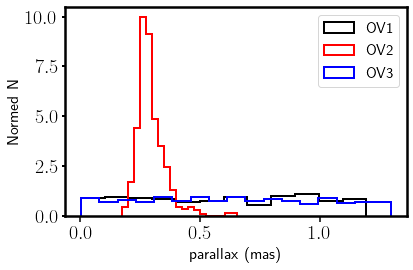

In [35]:
p.figure()
p.hist(T2['parallax'][CL1_2], color='k',histtype='step',label='OV1',lw=2,density=True,bins='scott')
p.hist(T2['parallax'][CL2_2], color='r',histtype='step',label='OV2',lw=2,density=True,bins='scott')
p.hist(T2['parallax'][CL3_2], color='b',histtype='step',label='OV3',lw=2,density=True,bins='scott')

p.legend()
p.xlabel('parallax (mas)');p.ylabel('Normed N')
p.tight_layout()


Q7 : How many real clusters are in Pointing 2? How do you know?

A7: There is 1 cluster in pointing 2 since it clumps in ra/dec/parallax/pmra/pmdec space. The parallax distribution of the second overdensity is uniform NOT peaked as such the stars are uniformly distributed along the line of sight. Therefore cluster 2 is *NOT* a cluster. NOTE: It also clumps in RV space but there are not enough RVs 


For any real cluster, compute the median and standard deivation of the parallaxes

In [36]:
#2pts
#insert code here.

In [37]:
medpar = np.median(T2['parallax'][CL2_2])
stdpar = np.std(T2['parallax'][CL2_2])
print('The median (std) parallax is %.2f (%.2f) with %i stars'%(medpar, stdpar, len(CL1)))

The median (std) parallax is 0.28 (0.06) with 986 stars


Q8: What is the median distance to any clusters you found in pointing 2 (ignore the effects of parallax uncertainties)?

A8: The cluster is Cluster 2/ NGC2506. The median parallax is 0.28 mas and thus this cluster is at a distance of ~3.57 kpc. The true cluster is NGC2506 and is at a distance of 3.44 kpc

## Plot the Color-Abs magnitude Diagram for Clusters in Pointing 1 and Pointing 2
Lets now plot the combined Color absolute magntiude diagram for each cluster found in pointing 1 and 2. Lets make sure to plot them on the same diagram for comparision. 

Below plot the color-abs. magnitude diagram (bp-rp) vs M_G for all "true" clusters

In [38]:
#8pts
#insert code here.

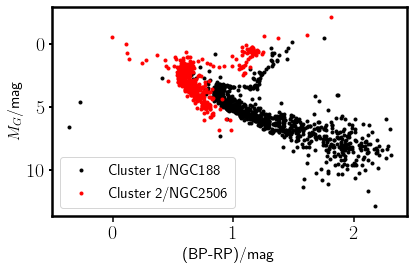

In [39]:
#lets now compute the absolute magnitude
T['absG'] = T['phot_g_mean_mag'] - 5*(np.log10(1000/T['parallax'])-1)
T2['absG'] = T2['phot_g_mean_mag'] - 5*(np.log10(1000/T2['parallax'])-1)

#lets now plot any found clusters on the same diagram!
p.figure()
p.plot(T['bp_rp'][CL1], T['absG'][CL1],'k.',label='Cluster 1/NGC188')
p.plot(T2['bp_rp'][CL2_2], T2['absG'][CL2_2],'r.',label='Cluster 2/NGC2506')
p.xlabel('(BP-RP)/mag')
p.ylabel(r'$M_G$/mag')
p.legend()
p.gca().invert_yaxis()
p.tight_layout()